In [68]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import (
    Input,
    Dense,
)
from tensorflow.keras.models import Model

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [69]:
print(f"Tensorflow datasets: {tfds.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")

Tensorflow datasets: 4.2.0
Tensorflow: 2.4.1
Numpy: 1.19.5
Matplotlib: 3.4.1


In [70]:
import pump
data_dir = "../dataset"

(train, test), info = tfds.load('pump', split=["train", "test"], data_dir=data_dir, with_info=True)

In [71]:
tfds.as_dataframe(train.take(1), info)

audio audio/id audio/machine  \
0  [-414, -319, -142, -207, -265, -95, -135, -259...  b'0028'         b'00'   

   audio/split  label  
0            0      0

In [72]:
df = tfds.as_dataframe(train.take(5), info)
df.head()

,audio,audio/id,audio/machine,audio/split,label
0,"[-414, -319, -142, -207, -265, -95, -135, -259...",b'0028',b'00',0,0
1,"[544, 612, 604, 695, 645, 490, 306, 379, 383, ...",b'0006',b'00',0,0
2,"[145, 316, 377, 557, 477, 437, 475, 388, 321, ...",b'0016',b'00',0,0
3,"[-227, -192, -46, 170, 81, -77, -141, -118, -4...",b'0019',b'00',0,0
4,"[141, 88, -66, -253, -391, -150, -162, -823, -...",b'0012',b'00',0,0


In [73]:
(train, test), info = tfds.load('pump', split=["train", "test"], as_supervised=True, data_dir=data_dir, with_info=True)

In [74]:
tfds.as_dataframe(train.take(1), info)

audio  label
0  [-414, -319, -142, -207, -265, -95, -135, -259...      0

In [75]:
def spectral_centroid(audio, label):
    audio = tf.cast(audio, dtype = tf.float32)
    audio = audio / 2**15
    audio = tf.signal.stft(audio, frame_length=1024, frame_step=512)
    audio = tf.abs(audio)
    freqs = tf.constant(np.arange(0,513), dtype=audio.dtype)
    audio = tf.reduce_sum(audio * freqs, axis=1) / tf.reduce_sum(audio, axis=1)
    return audio, audio

In [76]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 32

audio_train = train.map(spectral_centroid).batch(BATCH_SIZE)
label_train = train.map(lambda _, label: label).batch(BATCH_SIZE)

audio_test = test.map(spectral_centroid).batch(BATCH_SIZE)
label_test = test.map(lambda _, label: label).batch(BATCH_SIZE)

In [77]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential(
            [
                Input(shape=311),
                Dense(units=128, activation='relu'),
                Dense(units=16, activation="relu"),
            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                Dense(units=128, activation='relu'),
                Dense(311, activation="sigmoid"),
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = AnomalyDetector()

In [78]:
def custom_loss(y_true, y_pred):
    return tf.reduce_mean((y_true - y_pred)**2, axis=1)

In [79]:
autoencoder.compile(optimizer='adam', loss=custom_loss)

In [80]:
history = autoencoder.fit(audio_train,
                epochs=20,
                shuffle=True,
                validation_data=audio_test)

Epoch 1/20
2/2 [==============================] - 5s 2s/step - loss: 19521.3555 - val_loss: 19476.8652
Epoch 2/20
2/2 [==============================] - 1s 1s/step - loss: 19496.5560 - val_loss: 19459.2402
Epoch 3/20
2/2 [==============================] - 1s 987ms/step - loss: 19479.9036 - val_loss: 19447.9648
Epoch 4/20
2/2 [==============================] - 1s 1s/step - loss: 19469.3444 - val_loss: 19439.4980
Epoch 5/20
2/2 [==============================] - 1s 1s/step - loss: 19461.1185 - val_loss: 19434.3281
Epoch 6/20
2/2 [==============================] - 1s 980ms/step - loss: 19456.3796 - val_loss: 19431.2344
Epoch 7/20
2/2 [==============================] - 1s 1s/step - loss: 19453.6361 - val_loss: 19428.9102
Epoch 8/20
2/2 [==============================] - 1s 971ms/step - loss: 19450.6432 - val_loss: 19425.4727
Epoch 9/20
2/2 [==============================] - 1s 971ms/step - loss: 19448.0970 - val_loss: 19422.3613
Epoch 10/20
2/2 [==============================] - 1s 972ms/s

In [81]:
autoencoder.summary()

Model: "anomaly_detector_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 16)                42000     
_________________________________________________________________
sequential_7 (Sequential)    (None, 311)               42295     
Total params: 84,295
Trainable params: 84,295
Non-trainable params: 0
_________________________________________________________________


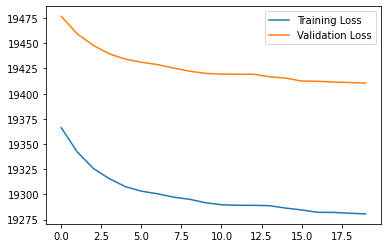

In [82]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

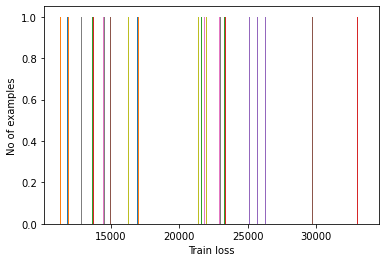

In [83]:
reconstructions = autoencoder.predict(audio_train)
audio_train2 = np.stack(audio_train.unbatch().map(lambda x, _: x), axis=1).T

train_loss = custom_loss(audio_train2, reconstructions)

plt.hist(train_loss, bins=10)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [84]:
threshold = np.mean(train_loss) + np.std(train_loss)
print(threshold)

24924.37


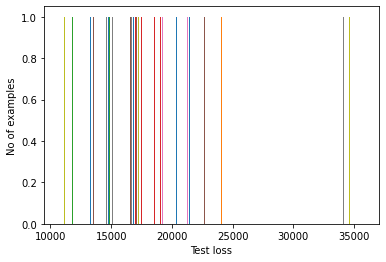

In [85]:
reconstructions = autoencoder.predict(audio_test)
audio_test2 = np.stack(audio_test.unbatch().map(lambda x, _: x), axis=1).T

test_loss = custom_loss(audio_test2, reconstructions)

plt.hist(test_loss, bins=10)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()